<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/build-text-to-image-generator-from-scratch)/01_vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Chapter 3: Classify Images with a Vision Transformer (ViT)**

This is for the book Build a Text to Image Generator from Scratch by Mark Liu, published by Manning Publications. See https://mng.bz/vZem and https://github.com/markhliu for details.

Be sure to set the runtime type of this colab notebook to GPU

In [1]:
# clone the book's GitHub repository
!git clone https://github.com/markhliu/txt2img

Cloning into 'txt2img'...
remote: Enumerating objects: 436, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 436 (delta 83), reused 10 (delta 10), pack-reused 281 (from 2)
Receiving objects: 100% (436/436), 117.75 MiB | 16.28 MiB/s, done.
Resolving deltas: 100% (191/191), done.


In [2]:
# allow access to local modules and files in the book's repository
import sys
sys.path.append("/content/txt2img")

## CIFAR-10 dataset

In [3]:
import torchvision

trainset=torchvision.datasets.CIFAR10(root=r'.', train=True, download=True)

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


To convert these numbers into meaningful object names.

In [4]:
names = ['plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck']


Next, we plot the first 18 images in the training set.

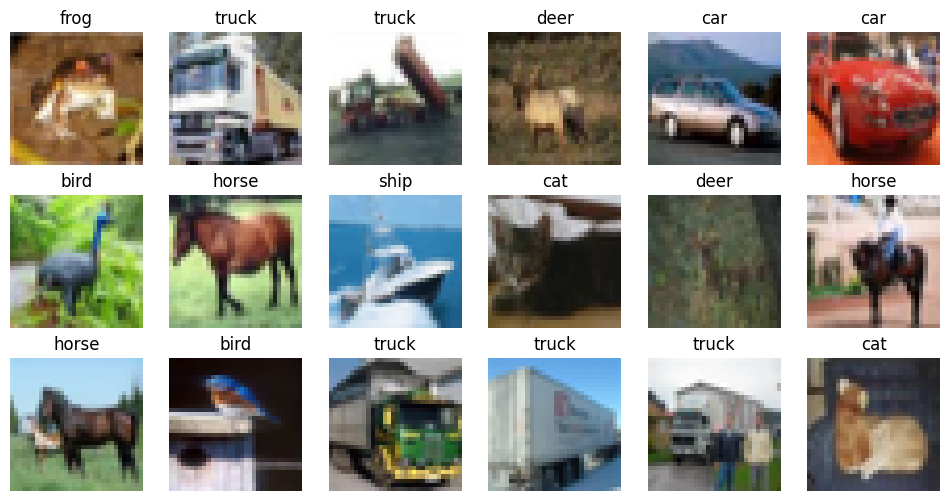

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,6),dpi=100)
for i in range(3):
    for j in range(6):
        plt.subplot(3, 6, 6*i+j+1)
        plt.imshow(trainset[6*i+j][0])
        plt.axis('off')
        plt.title(names[trainset[6*i+j][1]], fontsize=12)
plt.subplots_adjust(hspace=0.20)
plt.show()

We also download the test set for out-of-the-sample testing to ensure our trained model
isn’t overfit.

In [6]:
testset=torchvision.datasets.CIFAR10(root=r'.', train=False, download=True)

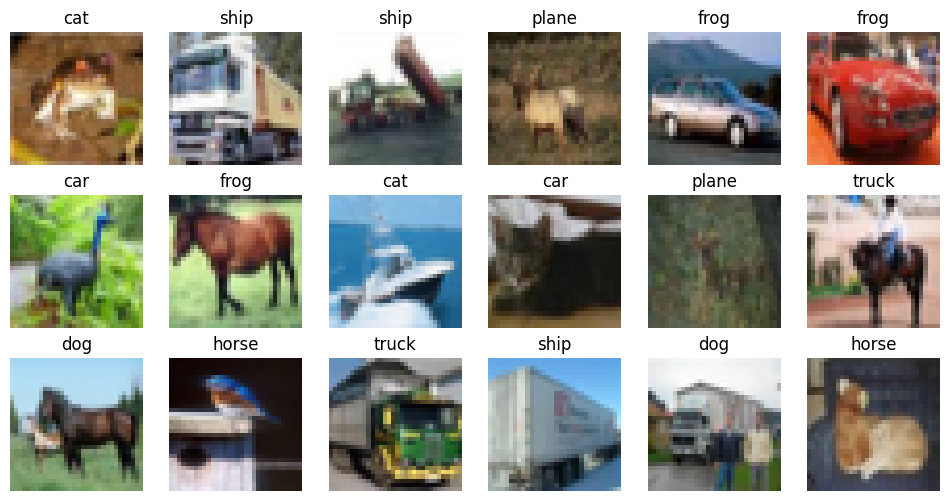

In [7]:
# Plot the first 18 images in the test dataset in a 3 × 6 grid.
plt.figure(figsize=(12,6),dpi=100)
for i in range(3):
    for j in range(6):
        plt.subplot(3, 6, 6*i+j+1)
        plt.imshow(trainset[6*i+j][0])
        plt.axis('off')
        plt.title(names[testset[6*i+j][1]], fontsize=12)
plt.subplots_adjust(hspace=0.20)
plt.show()

##Preparing datasets

We first transform
the training set as follows:

In [8]:
import torchvision.transforms as transforms

trainset.transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((32, 32),antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(
        (32, 32), scale=(0.8, 1.0),
        ratio=(0.75, 1.3333333333333333),
        interpolation=2,antialias=True
    ),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

Next, we place the training data in
batches for training:

In [9]:
import torch

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

We apply similar transformations on the test set and place them in batches as well:

In [10]:
testset.transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((32, 32),antialias=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

## Building ViT from scratch

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setting model hyperparameters
class Config:
    patch_size=4  # Each image patch has a height and width of 4 pixels
    hidden_size=48  # Each image patch is converted to a 48-value tensor
    num_hidden_layers=4
    num_attention_heads=4
    intermediate_size= 4 * 48
    image_size=32
    num_classes=10
    num_channels=3

config=Config()

## Dividing images into patches

In [12]:
from torch import nn
class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.projection = nn.Conv2d(  # Pass the image through a Conv2d() layer
            config.num_channels,
            config.hidden_size,
            kernel_size=config.patch_size,  # Set the kernel size to 4, which equals the patch size
            stride=config.patch_size  # Set the stride size to 4, which equals the patch size
        )
    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)  # Rearrange the output so it has a dimension of 64x48
        return x

In [19]:
# Converting image patches into a sequence
patch_embeddings=PatchEmbeddings(config)
img=torch.randn((1,3,32,32))  # Create a hypothetical image
out=patch_embeddings(img)  # Pass the image through the PatchEmbeddings() class
print(out.shape)

torch.Size([1, 64, 48])


In [14]:
patch_embeddings=PatchEmbeddings(config)
img=torch.randn((5,3,32,32))  # Create a batch of 5 hypothetical image
out=patch_embeddings(img)  # Pass the image through the PatchEmbeddings() class
print(out.shape)

torch.Size([5, 64, 48])


## Image embedding

In [16]:
class ImageEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        self.cls_token = nn.Parameter( # Add the CLS token to the beginning of the sequence
            torch.randn(1, 1, config.hidden_size)
        )
        num_patches = (config.image_size // config.patch_size) ** 2
        # Use learned positional encoding, with a dimension of (65, 48)
        self.position_embeddings = nn.Parameter(torch.randn(1,num_patches+1,config.hidden_size))
    def forward(self, x):
        x = self.patch_embeddings(x)  # Pass the image through the PatchEmbeddings() class
        batch_size, _, _ = x.size()
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # Embed the image, with a dimension of (65, 48)
        x = x + self.position_embeddings  # Add positional encoding to the image embedding
        return x

In [18]:
image_embeddings=ImageEmbeddings(config)
img=torch.randn((1,3,32,32))  # Create a hypothetical image
out=image_embeddings(img)  # Pass the image through the class
print(out.shape)  #C
print(image_embeddings.position_embeddings.shape)

torch.Size([1, 65, 48])
torch.Size([1, 65, 48])


In [20]:
img=torch.randn((5,3,32,32))  # Create a hypothetical image
out=image_embeddings(img)  # Pass the image through the class
print(out.shape)  #C
print(image_embeddings.position_embeddings.shape)

torch.Size([5, 65, 48])
torch.Size([1, 65, 48])


## Attention mechanism

In [21]:
class AttentionHead(nn.Module):
    def __init__(self, hidden_size, attention_head_size, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)
    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)  # Calculate query, key, and value vectors
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)  # Calculate attention weights
        attention_output = torch.matmul(attention_probs, value)  #C
        return (attention_output, attention_probs)

## Encoder-only transformer

In [35]:
from utils.ViTutil import GELU

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        # The first linear layer, with 48 input channels and 4*48=192 output channels
        self.dense_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.activation = GELU()  # With GELU activation
        # The second linear layer, with 192 input channels and 48 output channels
        self.dense_2 = nn.Linear(config.intermediate_size, config.hidden_size)
    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        return x

In [31]:
from utils.ViTutil import MultiHeadAttention

# Creating an encoder block
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config.hidden_size)
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config.hidden_size)
    def forward(self, x, output_attentions=False):
        # The input first goes through layer normalization, then the multi-head attention layer
        attention_output, attention_probs = self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        x = x + attention_output  # Apply residual connections
        # Go through layer normalization again, then the feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        x = x + mlp_output  # Apply residual connections again
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)

In [32]:
# Creating an encoder-only transformer
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.blocks = nn.ModuleList([])
        for _ in range(config.num_hidden_layers):
            block = Block(config)
            self.blocks.append(block)  # Stack four encoder layers together
    def forward(self, x, output_attentions=False):
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x,
               output_attentions=output_attentions)  # The input goes through the four encoder layers sequentially
            if output_attentions:
                all_attentions.append(attention_probs)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)


In [33]:
class ViTForClassfication(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config.image_size
        self.hidden_size = config.hidden_size
        self.num_classes = config.num_classes
        self.image_embeddings = ImageEmbeddings(config)
        self.encoder = Encoder(config)
        # Attach a head at the end of the model to create a classifier, with 10 output classes
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        self.apply(self._init_weights)
    def forward(self, x, output_attentions=False):
        # Input images first go through the ImageEmbedding() class to generate input embeddings
        embedding_output = self.image_embeddings(x)
        # The input image embeddings go through the ViT to create encoder output
        encoder_output, all_attentions = self.encoder(embedding_output,output_attentions=output_attentions)
        # The encoder output goes through the classifier head to obtain the logits corresponding to the 10 classes of labels
        logits = self.classifier(encoder_output[:, 0, :])
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

## Training Image Classifer

In [37]:
from utils.ViTutil import ViTForClassfication

model = ViTForClassfication(config).to(device)

In [38]:
from torch import nn, optim

optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-2)

In [40]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
scaler = torch.amp.GradScaler()

In [ ]:
class EarlyStop:
    def __init__(self, patience=3):
        self.patience = patience
        self.steps = 0
        self.min_loss = float('inf')
    def stop(self, loss):
        if loss < self.min_loss:  #A
            self.min_loss = loss
            self.steps = 0
            to_save = True
        elif loss >= self.min_loss:  #B
            self.steps += 1
            to_save = False
        if self.steps >= self.patience:  #C
            to_stop = True
        else:
            to_stop = False
        return to_save, to_stop
stopper=EarlyStop()  #D
#A If the loss in the test set is smaller than the previously achieved minimum, keep training
#B If the loss in the test set is larger than the previously achieved minimum, add 1 to the counter
#C If the performance doesn’t improve in three consecutive epochs, stop training
#D Instantiate the EarlyStop() class



In [ ]:
def train_batch(batch):
    batch = [t.to(device) for t in batch]  #A
    images, labels = batch
    with torch.amp.autocast(device):
        loss = loss_fn(model(images)[0], labels)  #B
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    return loss.item()*len(images)/len(trainloader.dataset)  #C
#A Move training data to CUDA-enabled GPU, if available
#B Train the model with the batch of training data
#C Return the loss in the batch


In [ ]:
from tqdm import tqdm
import os
os.makedirs("files", exist_ok=True)
for i in range(100):
    print(f'Epoch {i+1}')
    model.train()
    trainL, testL = 0, 0
    for batch in tqdm(trainloader):  #A
        loss=train_batch(batch)
        trainL+=loss
    model.eval()
    with torch.no_grad():
        for batch in testloader:  #B
            batch = [t.to(device) for t in batch]
            images, labels = batch
            logits, _ = model(images)
            loss = loss_fn(logits, labels)
            testL+=loss.item()*len(images)/len(testloader.dataset)
    print(f'Train and test losses: {trainL:.4f}, {testL:.4f}')
    to_save, to_stop = stopper.stop(testL)
    if to_save==True:  #C
        torch.save(model.state_dict(),"/content/txt2img/files/ViT.pth")
    if to_stop==True:  #D
        break
#A Train the model for one epoch
#B Test the model in the test set
#C If the model performance improves in this epoch, save the model parameters
#D If the model fails to improve in three consecutive epochs, stop training



In [ ]:
import math
import torch.nn.functional as F

model.load_state_dict(torch.load('/content/txt2img/files/ViT.pth'))
model.eval()
with torch.no_grad():
    batch=next(iter(testloader))  #A
    batch = [t.to(device) for t in batch]
    images, labels = batch
    logits, attention_maps = model(images,
        output_attentions=True)  #B
    predictions = torch.argmax(logits, dim=1)  #C

print(predictions)
print([names[i] for i in predictions.tolist()])  #D
#A Obtain a batch of 32 images from the test dataset
#B Obtain logits and attention maps using the trained model
#C Make predictions based on the highest logits
#D Print out the names of the predicted labels



tensor([8, 8, 8, 0, 6, 6, 1, 6, 5, 1, 0, 9, 6, 7, 9, 8, 5, 7, 8, 6, 7, 2, 0, 1,
        4, 4, 4, 6, 1, 6, 6, 4], device='cuda:0')
['ship', 'ship', 'ship', 'plane', 'frog', 'frog', 'car', 'frog', 'dog', 'car', 'plane', 'truck', 'frog', 'horse', 'truck', 'ship', 'dog', 'horse', 'ship', 'frog', 'horse', 'bird', 'plane', 'car', 'deer', 'deer', 'deer', 'frog', 'car', 'frog', 'frog', 'deer']


In [ ]:
for attn in attention_maps:
    print(attn.shape)  #A
block0_image0_head0=attention_maps[0][0,0,:,:]  #B
print(block0_image0_head0.shape)
probs_sum=torch.sum(block0_image0_head0,dim=1)  #C
print(probs_sum)
#A The shape of the attention map in each encoder layer
#B The attention map for the first attention head in the first image in the first encoder layer
#C Add up the value of attention across columns


torch.Size([32, 4, 65, 65])
torch.Size([32, 4, 65, 65])
torch.Size([32, 4, 65, 65])
torch.Size([32, 4, 65, 65])
torch.Size([65, 65])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000], device='cuda:0')


attention map shape: torch.Size([32, 16, 65, 65])
attention map shape: torch.Size([32, 16, 64])
attention map shape: torch.Size([32, 64])
attention map shape: torch.Size([32, 8, 8])
attention map shape: torch.Size([32, 32, 32])


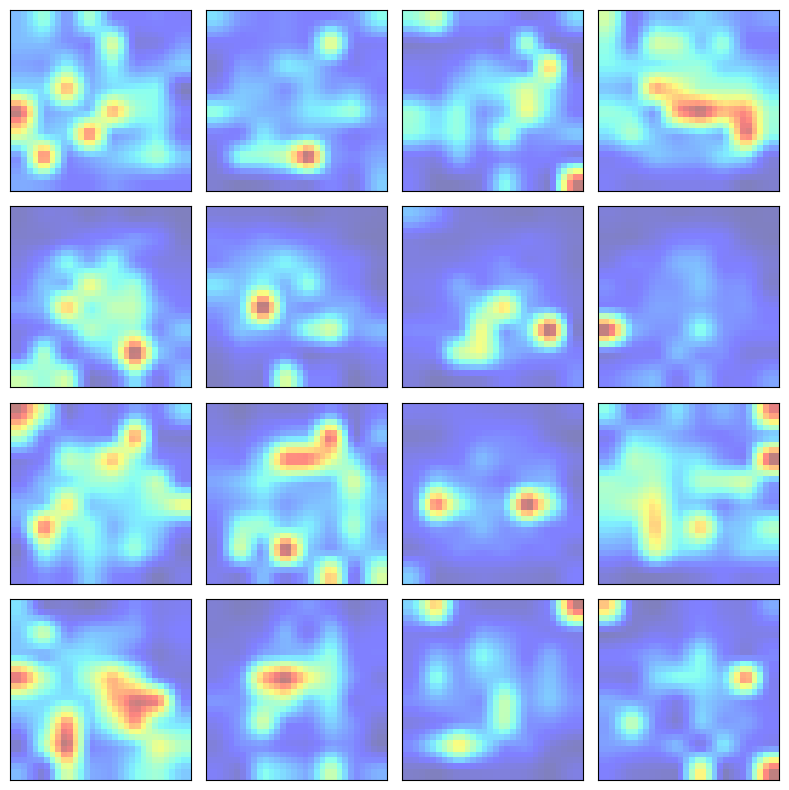

In [ ]:
with torch.no_grad():
    attention_maps = torch.cat(attention_maps, dim=1)  #A
    print(f"attention map shape: {attention_maps.shape}")
    attention_maps = attention_maps[:, :, 0, 1:]  #B
    print(f"attention map shape: {attention_maps.shape}")
    attention_maps = attention_maps.mean(dim=1)
    print(f"attention map shape: {attention_maps.shape}")
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(
        -1, size, size)  #C
    print(f"attention map shape: {attention_maps.shape}")
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32),
                       mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)  #D
    print(f"attention map shape: {attention_maps.shape}")

fig = plt.figure(figsize=(8, 8),dpi=100)
for i in range(16):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(attention_maps[i].cpu(), alpha=0.5, cmap='jet')
plt.tight_layout()
plt.show()  #E
#A Concatenate the attention maps from the four encoder layers into one
#B Focus on the attention between the CLP token and the 64 image tokens
#C Take average and resize the attention map into an 8x8 image
#D Upscale the attention map to a 32x32 image to match the original image size
#E Plot the attention map for each of the first 16 images in the batch


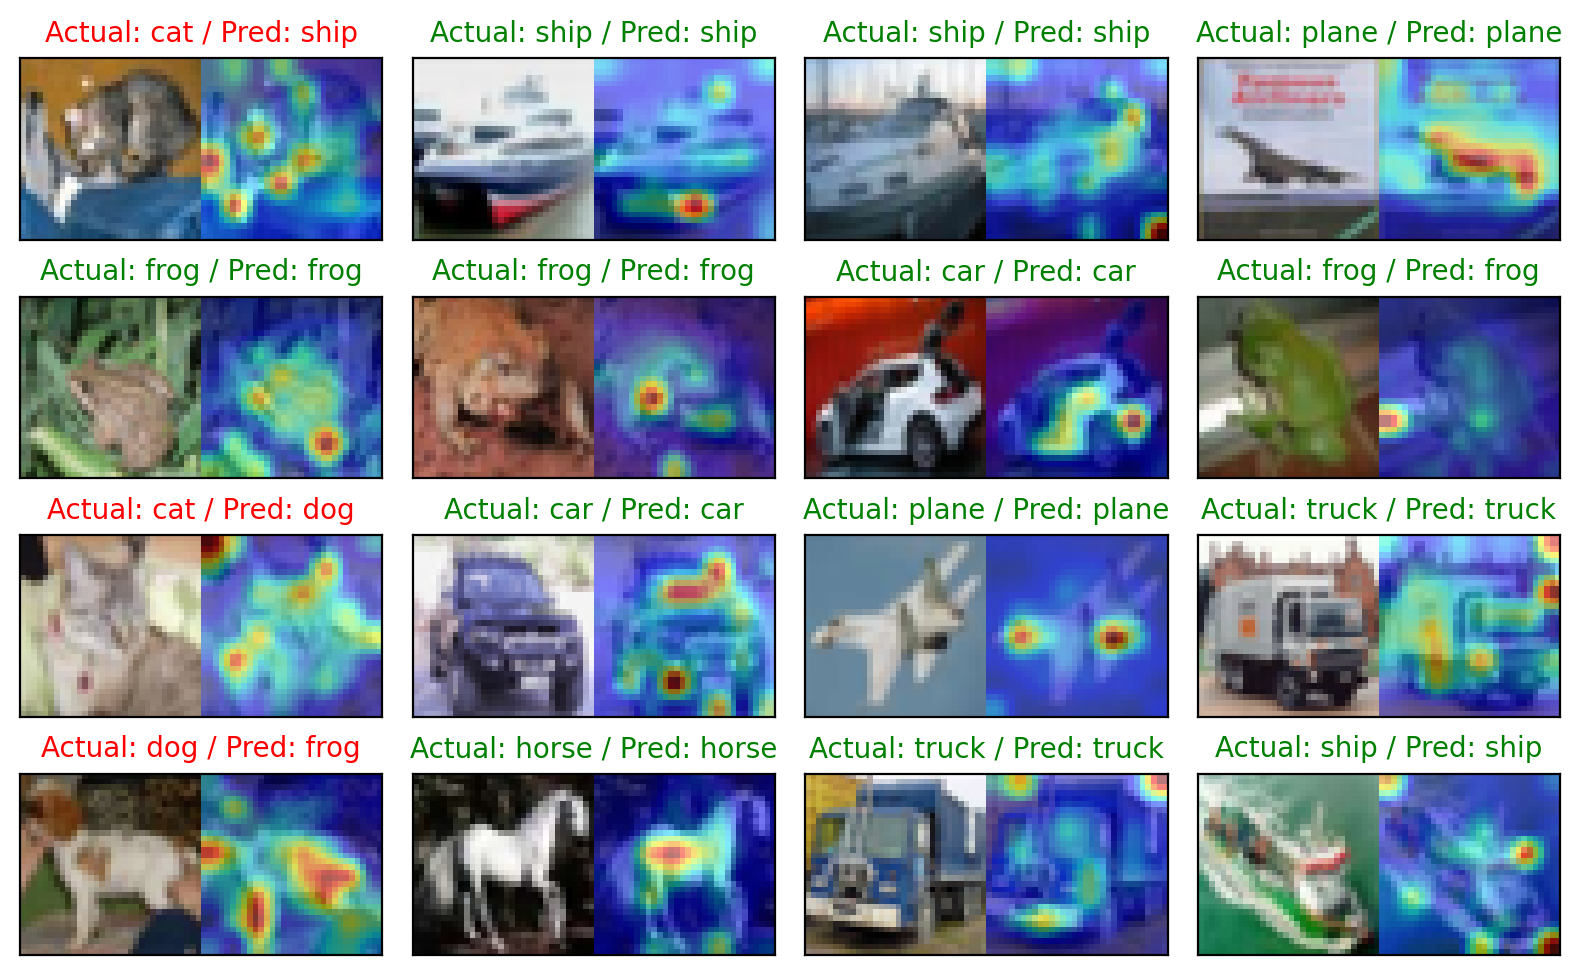

In [ ]:
fig = plt.figure(figsize=(8, 5),dpi=200)
mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))],
                      axis=1)
for i in range(16):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    img = np.concatenate((images[i].cpu(), images[i].cpu()),
                         axis=-1)
    ax.imshow(img.transpose(1,2,0)/2+0.5)  #A
    extended_attention_map = np.concatenate((np.zeros((32, 32)),
           attention_maps[i].cpu()),
           axis=1)
    extended_attention_map = np.ma.masked_where(mask==1,
           extended_attention_map)  #B
    ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
    gt = names[labels[i]]
    pred = names[predictions[i]]
    ax.set_title(f"Actual: {gt} / Pred: {pred}",
                 color=("green" if gt==pred else "red"),
                fontsize=10)  #C
plt.tight_layout()
plt.show()
#A Show the original image
#B Add the attention map to the right of the original image
#C Place both the original and the predicted labels on top of the image


In [ ]:
model.eval()
acc = 0
with torch.no_grad():
    for batch in testloader:  #A
        batch = [t.to(device) for t in batch]
        images, labels = batch
        logits, _ = model(images)
        predictions = torch.argmax(logits, dim=1)  #B
        acc += torch.sum(predictions ==\
             labels).item()/ len(testloader.dataset)
print(f'the prediction accuracy is {acc:.4f}')  #C
#A Iterate through all batches in the test dataset
#B Make predictions using the trained ViT classifier
#C Print out the overall accuracy of the predictions


the prediction accuracy is 0.5621
